## How to access, read and analyse datacubes from NBS

This tutorial demonstrates how to read and use Copernicus Sentinel-2 datacubes hosted on [satellittdata.no](https://www.satellittdata.no/) - the data portal for Norway’s national ground segment for satellite data (NBS). 

> **Note**: This tutorial is in development. The below functionality should work but we plan to expand this functionality in the future.

## Importing libraries

Note that the tuturial requires some standard libraries which can be installed by `pip install ...`

In [14]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import time

# For georeferencing
import cartopy.crs as ccrs

## Data cube URLs
Data cubes in the NBS project is made available by the original SAFE products, which are converted into [netCDF](https://docs.unidata.ucar.edu/netcdf-c/current/) using the [`safe_to_netcdf`](https://github.com/NasjonaltBakkeSegment/safe_to_netcdf) tool.

These products are disseminated on [nbstds.met.no](https://nbstds.met.no/thredds/catalog/NBS/DATACUBES/catalog.html) (where you can manually browse the catalog). All products contain a so-called OPeNDAP URL, which allows to "stream the data" product and corresponding data over the internet.

> **Note**: We currently have a one-year rolling archive on the Sentinel-2 data in netCDF, such that the datacube URLs suggested below might be outdated and must therefore be replaced


In [8]:
# List of example data cubes

available_dcs = ['https://nbstds.met.no/thredds/dodsC/NetCDF-ondemand-products/datacubes/L2A/T32VNM/datacubes/S2_L2A_T32VNM_2025.ncml',
                 'https://nbstds.met.no/thredds/dodsC/NetCDF-ondemand-products/datacubes/L2A/T32VNM/datacubes/S2_L2A_T32VNM_2024.ncml',                 
                ]



## Reading datacubes 
Now we want to read the datacubes. Below we provide two different options, namely the native netcdf4 package in python and xarray, where the latter is becoming a standard tool in the geophysics community

> **Note**: If the datacube havent been read for a while, it is not cached on the server, and the read time would typically be on the order of a minute. If it has been read recently, and thus cached, read time is typically around a couple of seconds


In [12]:
use_netcdf4 = False
# Iterate through list of DCs
for dc in available_dcs:
    start_reading = time.time()
    
    # Reading the data. NOTE: Might take some time    
    if use_netcdf4:
        try:
            ncin = Dataset(dc)
        except:
            print('Exception for {}'.format(dc))            
    else:
        try:
            ncin = xr.open_dataset(dc)
        except:
            print('Exception for {}'.format(dc))

    # Monitoring the read time
    end_reading = time.time()
    dt = end_reading - start_reading
    print(f'Read time in seconds: {dt}')



Read time in seconds: 18.62463355064392
Read time in seconds: 24.062914848327637


## Spatio-temporal coverage of the data cube

We start by looking at the entire spatio-temporal domain of the data cube. Afterwards, we will look into a specific subregion.

Spatial covergae: Plot the tile on a map  

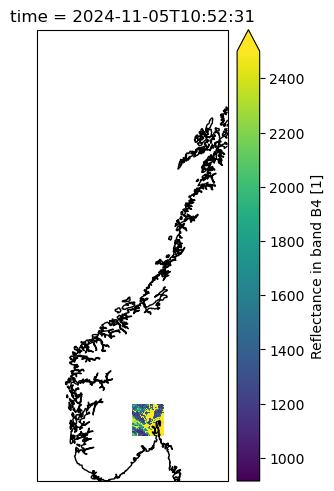

In [35]:
projection = ccrs.epsg(ncin.UTM_projection.epsg_code)
fig = plt.figure(layout='compressed')
ax = fig.add_subplot(1, 1, 1, projection=projection)

ncin.B4.isel(time=12)[::20,::20].plot(vmax=2500)

#ax.set_xlim(0,20,crs=ccrs.PlateCarree())

ax.set_extent([0,25,58,72],crs=ccrs.PlateCarree())
ax.coastlines()


Temporal covergae: Number of products within data cube period

In [78]:
date_start=ncin.time.min().values
date_end=ncin.time.max().values

# Convert to datetime64[D] to get only the date
date_start = date_start.astype('datetime64[D]')
date_end = date_end.astype('datetime64[D]')

print(f"Number of scenes from {date_start} to {date_end}: {ncin.time.size}")

Number of scenes from 2024-01-02 to 2024-12-30: 208


Text(0, 0.5, 'Relative orbit number')

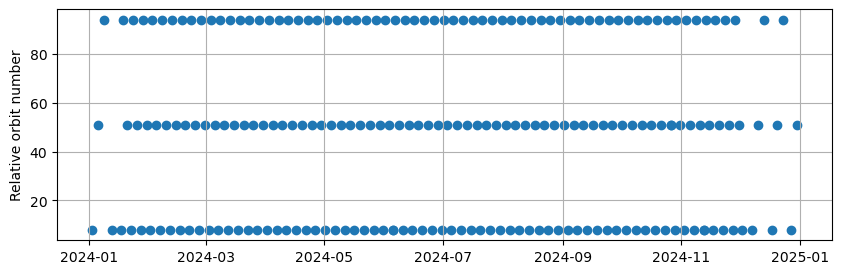

In [99]:
# Plotting acquisition time as a function of relative orbit number

fig,ax=plt.subplots(figsize=(10,3))

ax.scatter(ncin.time,ncin.orbit_data.isel(orbit_dim=0).values)
ax.grid()
ax.set_ylabel('Relative orbit number')


## Scene coverage
We can also investigate the scene coverage of each acquisition, knowing that the splitting of Sentinel-2 passes will lead to very limited coverage for some orbits.


> **Note**: Computing the `tile_coverage`variable below is very slow, and we are looking into making this parameter available as a variable within the datacube

In [114]:
tile_coverage = [np.isnan(ncin.B4.isel(time=i)).sum()/(10980*10980) for i in range(ncin.time.size)]

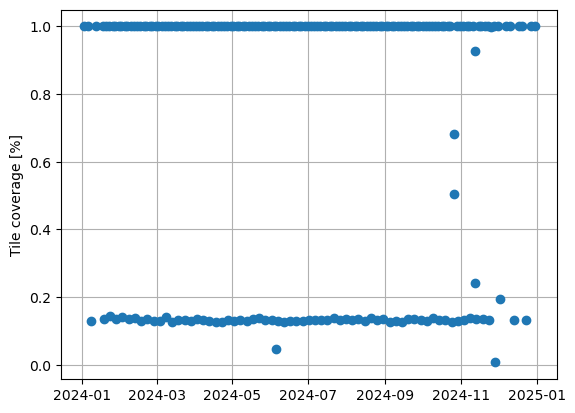

In [185]:
tile_coverage = np.array(1-tile_coverage)

plt.plot(ncin.time,tile_coverage,'o')
plt.ylabel('Tile coverage [%]')
plt.grid()

In [186]:
# Number of scences with tile_coverage above threshold
tile_coverage_threshold = 0.2
print(f'Nb. scenes with tile coverage above {tile_coverage_threshold*100}%: {np.sum(tile_coverage>0.2)}')
print(f'Percentage of products in datacube with tile coverage above {tile_coverage_threshold*100}%: {100*np.sum(tile_coverage>0.2)/ncin.time.size}%')


Nb. scenes with tile coverage above 20.0%: 139
Percentage of products in datacube with tile coverage above 20.0%: 66.82692307692308%


In [187]:
# Add the tile_coverage as a variable of the datacube
ncin["tile_coverage"] = (("time"), tile_coverage)

## Work on the data of interest in a specific subregion
The benefits of datacubes really become obvious if we are interested in a specific sub-area in a tile.

Here, we will look at the lake ice conditions in Follsjø - an inland lake in the municipality of Notodden.

In the plot below, you see where it is located within the tile. Note, we found the coordinates of the lake by looking at the coordinates of the tile


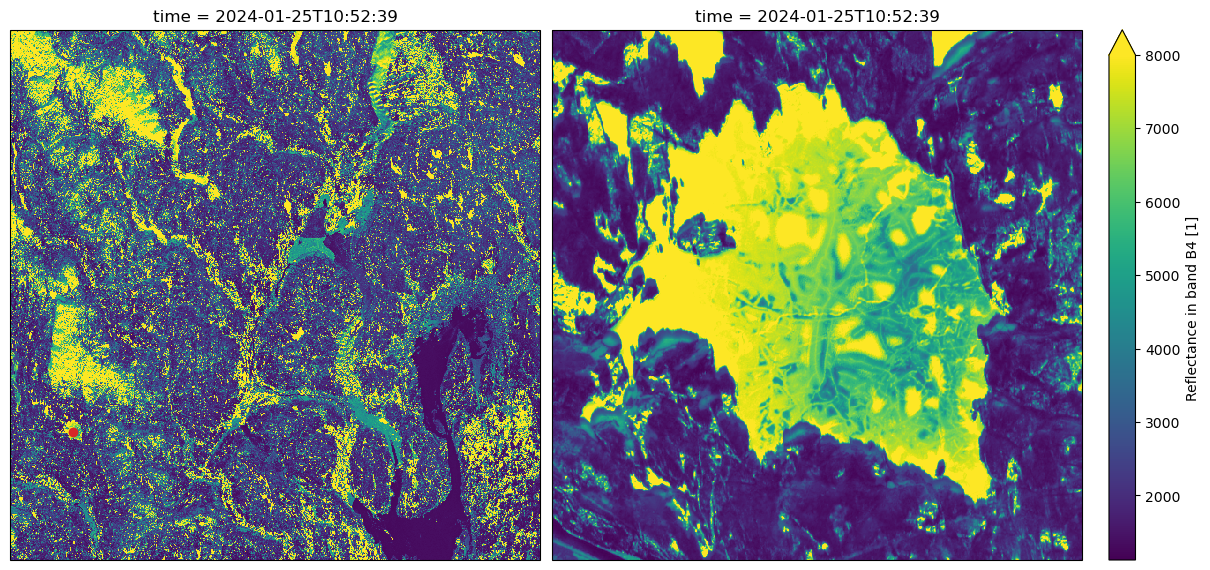

In [161]:
fig = plt.figure(layout='compressed',figsize=(12,8))
ax1 = fig.add_subplot(1, 2, 1, projection=projection)
ax2 = fig.add_subplot(1, 2, 2, projection=projection)

ncin.B4.isel(time=25)[::20,::20].plot(ax=ax1,vmax=8000,add_colorbar=False)
ax1.scatter(9.23,59.69,c='tab:red',transform=ccrs.PlateCarree())


x_start,x_end = 510000,516000
y_start,y_end = 6620000,6614000 # NOTE: y-values are decreasing!

ncin.B4.isel(time=25).sel(x=slice(x_start,x_end),y=slice(y_start,y_end)).plot(ax=ax2,vmax=8000)

## Removing scenes with no data + clouds from datacube
Now, we do the same tile_coverage operation as before, but we also do a cloud coverage filetering based on a threshold, using the cloud parameters included in the datacube.

Note, we now just work on a subset of the data in terms of its spatial domain

In [164]:
ds_follsjo = ncin.sel(x=slice(x_start,x_end),y=slice(y_start,y_end))

In [170]:
print(f'Percentage number of pixels compared with the full tile: {100*ds_follsjo.B4.size/ncin.B4.size}')

Percentage number of pixels compared with the full tile: 0.2996016934250384


In [188]:
tile_coverage_follsjo = np.array([1-np.isnan(ds_follsjo.B4.isel(time=i)).sum()/(ds_follsjo.B4.size) for i in range(ncin.time.size)])

In [249]:
cloud_coverage_follsjo = np.array([np.nanmean(ds_follsjo.isel(time=i).MSK_CLDPRB.values.ravel()) for i in range(ds_follsjo.time.size)])

/tmp/ipykernel_98748/2961779383.py:1: RuntimeWarning: Mean of empty slice
  cloud_coverage_follsjo = np.array([np.nanmean(ds_follsjo.isel(time=i).MSK_CLDPRB.values.ravel()) for i in range(ds_follsjo.time.size)])


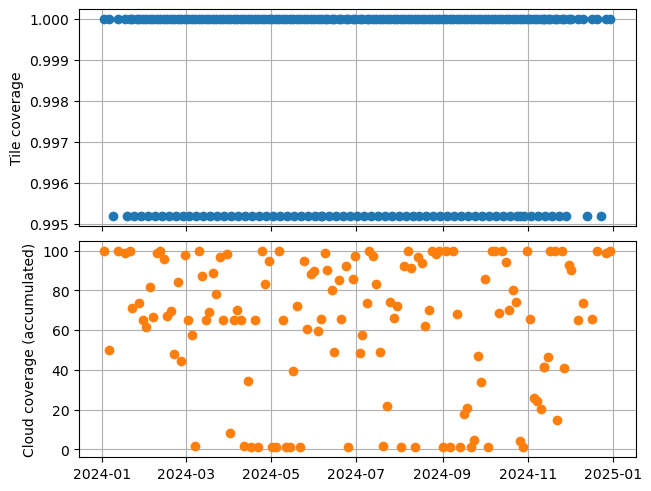

In [257]:
fig,ax = plt.subplots(nrows=2,sharex=True,layout='compressed')

ax[0].plot(ds_follsjo.time,tile_coverage_follsjo,'o')
ax[1].plot(ds_follsjo.time,cloud_coverage_follsjo,'o',c='tab:orange')

ax[0].set_ylabel('Tile coverage')
ax[1].set_ylabel('Cloud coverage (accumulated)')

for aax in ax:
    aax.grid()

Since the cloud coverage is a valuable parameter, we add this to the xarray dataset. On the other hand, due to the location of follsjø, it is always covered by the satellite swath so we ignore this parameter.

In [258]:
# Add the tile_coverage as a variable of the datacube
ds_follsjo["cloud_coverage"] = (("time"), cloud_coverage_follsjo)

## Lake ice coverage over Follsjø

We can now compute the lake ice coverage. Here we will show two different steps:

1. We the traditional `Normalized Difference Snow Index` parameter, which for Sentinel-2 will be computed from frequency bands B3 and B11.
2. We make use of the scene classification variable `SCL` already available as a raster in the datacube
   
For the analysis, we therefore subset the data set in terms of our variables of interest (i.e., we skip those that are not relevant now), and we filter on cloud coverage.

In [428]:
# Variables of interest
VOI = [ 
    'B3',
    'B11',
    'SCL',
    'cloud_coverage',
]

In [429]:
ds_analysis = ds_follsjo[VOI]

Now we just do this analysis for two different times, where we already know that there is a different season

NOTE: the cloud mask from the default products you cannot always trust. For instance, the scene with ID=25 has no clouds, but from the cloud probability mask the values were not-a-number.

In [430]:
NDSIs = np.zeros((ds_analysis.B3.shape))

for i in range(ds_analysis.time.size):
    cc = ds_analysis.isel(time=i).cloud_coverage.values
    if cc<20 or i==25:
        print(i)
        b11 = ds_analysis.B11.isel(time=i).values
        b3 = ds_analysis.B3.isel(time=i).values

        NDSI = 0.0 + (b3 - b11)/(b3 + b11)*1.0
        NDSIs[i,:,:]=NDSI
    
    if i >25:
        break

4
25


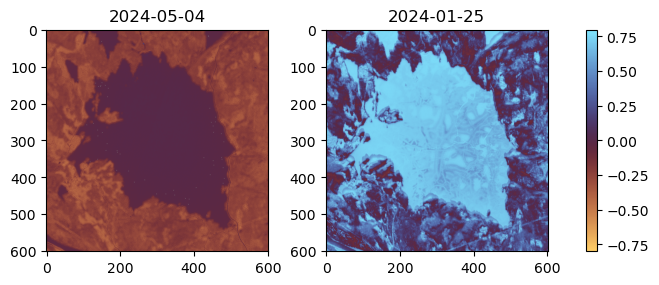

In [436]:
fig,ax = plt.subplots(ncols=2,sharex=True,layout='compressed')
pc=ax[0].imshow(NDSIs[4,:,:],cmap='managua',vmin=-.8,vmax=.8);
ax[1].imshow(NDSIs[25,:,:],cmap='managua',vmin=-.8,vmax=.8);

ax[0].set_title(f"{ds_analysis.time[4].values.astype('datetime64[D]')}")
ax[1].set_title(f"{ds_analysis.time[25].values.astype('datetime64[D]')}")

cb = fig.colorbar(pc,ax=ax)

Here, the NDSI is color coded such that higher values indicate lower temperatures.

Below, you see the SCL segmentation field for the january case:

[Text(1, 0, 'NODATA'),
 Text(1, 1, 'SATURATED_DEFECTIVE'),
 Text(1, 2, 'DARK_FEATURE_SHADOW'),
 Text(1, 3, 'CLOUD_SHADOW'),
 Text(1, 4, 'VEGETATION'),
 Text(1, 5, 'NOT_VEGETATED'),
 Text(1, 6, 'WATER'),
 Text(1, 7, 'UNCLASSIFIED'),
 Text(1, 8, 'CLOUD_MEDIUM_PROBA'),
 Text(1, 9, 'CLOUD_HIGH_PROBA'),
 Text(1, 10, 'THIN_CIRRUS'),
 Text(1, 11, 'SNOW_ICE')]

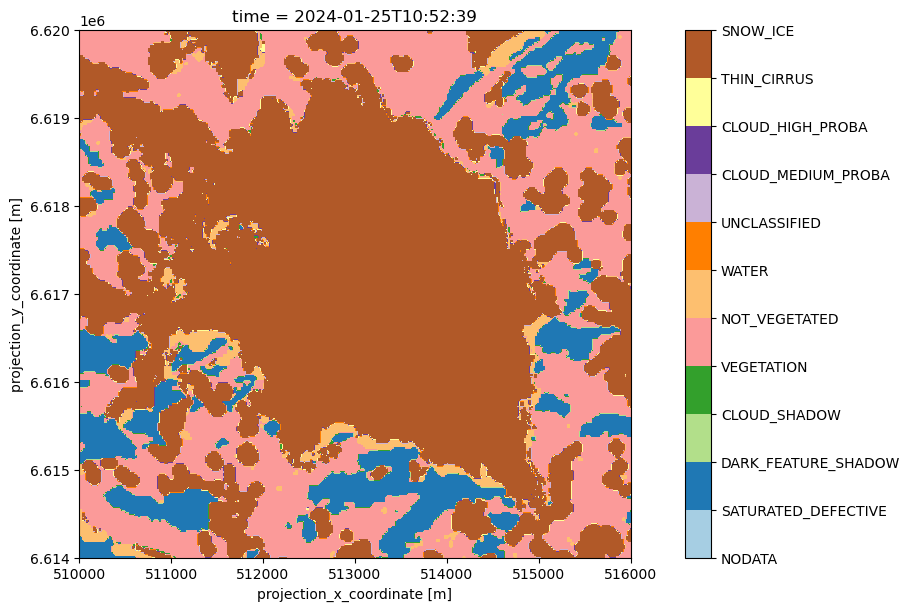

In [467]:
fig,ax = plt.subplots(layout='compressed',figsize=(9,6))
cax = ds_follsjo.SCL.isel(time=25).plot.contourf(levels=np.arange(len(ds_follsjo.SCL.flag_values)), 
                                                         cmap='Paired', ax=ax, add_colorbar=False)
cbar = fig.colorbar(cax, ticks=ncin.SCL.flag_values, orientation='vertical')
cbar.ax.set_yticklabels(ncin.SCL.flag_meanings.split(' '))

Clearly, the SNOW_ICE mask properly. However, there are points outside of the lake that are also classified as SNOW_ICE, which is not lake ice

## Look at the temporal evolution in lake ice cover using the SCL variable
This is an inexact way of classifying lake ice cover, but it works for the purpose of illustration.

From visual inspection, we see that the lake covers about 60% of the image. We therefore compute sea ice coverage as

$$c=\frac{N_i}{N_p},$$

where $N_i$, $N_p$ are the number of pixels classified as "SNOW_ICE" and number of pixels approximately representing the lake. As such, if $c>1$, this indicates that additional points not covering the lake are also accounted for.


In [445]:
Np = ds_analysis.B11.isel(time=0).size*0.6 # 60% of the pixels
Ni = np.array([np.nansum(ds_follsjo.SCL.isel(time=i)==11) for i in range(ds_analysis.time.size)]) #11 is the SNOW_ICE class

Finally, we plot a condensed view the sea ice coverage as a function of time, colored by the cloud coverage.

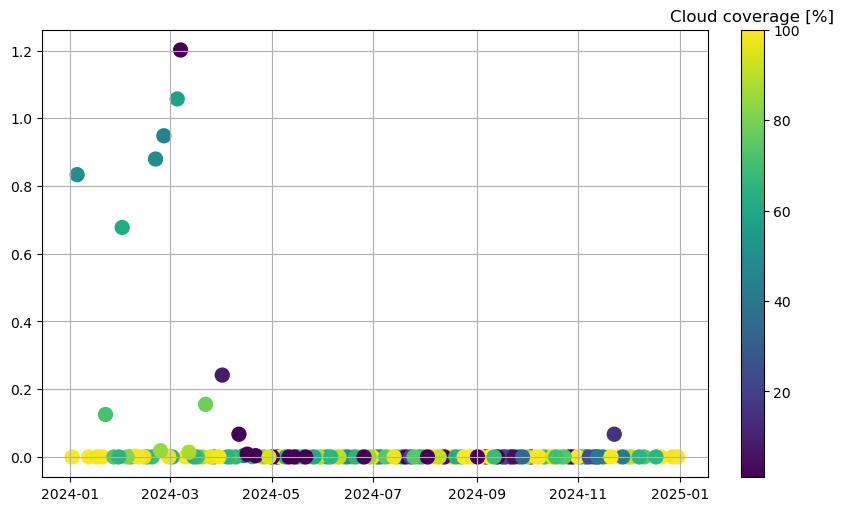

In [499]:
fig,ax = plt.subplots(layout='compressed',figsize=(8,5))
sc=ax.scatter(ds_analysis.time,Ni/Np,c=ds_analysis.cloud_coverage,s=100)
cb = fig.colorbar(sc)
cb.ax.set_title('Cloud coverage [%]')
ax.grid()

## Sort the data for further analysis
For other types of analysis, it is normal to sort the products on time. This is easily taken care of by xarray

In [501]:
ds_a_sort=ds_analysis.sortby('time')

Then, if we rely on the scene classification variable, we can simply plot a time series of the scene classification variable for a point in the middle of the lake.

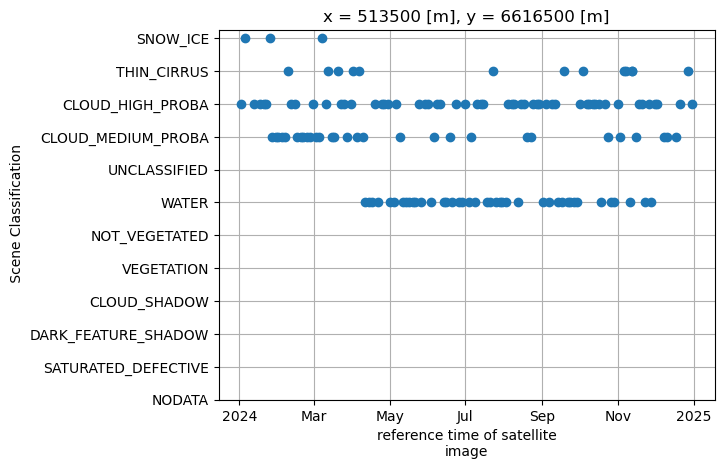

In [526]:
fig,ax=plt.subplots()
ds_a_sort.SCL.isel(x=350,y=350).plot.line(ax=ax,ls='',marker='o')
ax.set_yticks(np.arange(0,12))
ax.set_yticklabels(ds_a_sort.SCL.flag_meanings.split(' '))
ax.grid()